# MSP Data Science Capstone Course

### Microsoft Project :- DAT102x: Predicting Mortgage Approvals From Government Data 

## Getting Started

#### Goal: 
To predict whether a mortgage application was accepted (meaning the loan was originated) or denied according to the given dataset, which is adapted from the [Federal Financial Institutions Examination Council's (FFIEC)](https://www.ffiec.gov/hmda/hmdaflat.htm).


[Jupyter Syntax](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html)

#### Target Variable

In this project, We're trying to predict the variable accepted (a binary variable) for each row of the test data set.

The task is to:

1. Train a model using the inputs in train_values.csv and the labels train_labels.csv
2. Predict value for each row in test_values.csv for which you don't know the true value of accepted.
3. Output your predictions in a format that matches submission_format.csv exactly.

#### Submission Format

The format for the submission file is two columns with row_id and accepted. The data type of accepted is an integer, only valid values are 0 and 1.

If you predicted 1 accepted for each respondent, the .csv file that you submit would look like:

|row_id| accepted |
|------|----------|
|0|1|
|1|1|
|2|1|
|3|1|
|4|1|


There are three files as follows:
- Submission format: A properly formatted submission file with all ones for prediction.
- Test values: Input variables (for the submission rows)
- Training labels: Labels (for the training set)
- Training inputs: Input variables (for the training set)

The train_labels file are our labels for the training set (X's) and the train_values are our input for the training set (Y's). The test_values file will be used to make predictions and is the basis for creating the submission file. 


In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math



from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import sklearn.metrics as sklm
from sklearn import feature_selection as fs
from sklearn import metrics
from sklearn.model_selection import cross_validate



%matplotlib inline

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Load training datasets
# Load the Home mortgage dataset
train_values_X = pd.read_csv('Data/train_values.csv')
train_labels_Y = pd.read_csv('Data/train_labels.csv')


# Success
print("Home mortgage training data inputs has {} data points with {} variables each.".format(*train_values_X.shape))
print("Home mortgage training data labels has {} data points with {} variables each.".format(*train_labels_Y.shape))

Home mortgage training data inputs has 500000 data points with 22 variables each.
Home mortgage training data labels has 500000 data points with 2 variables each.


In [3]:
display(train_values_X.head(),train_labels_Y.head())

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,0,3,1,1,1,70.000,3,18,37,246,...,1,24.000,6203.000,44.230,60588.000,50.933,716.000,2642.000,4536,False
1,1,1,1,3,1,178.000,3,369,52,299,...,1,57.000,5774.000,15.905,54821.000,100.000,1622.000,2108.000,2458,False
2,2,2,1,3,1,163.000,3,16,10,306,...,1,67.000,6094.000,61.270,67719.000,100.000,760.000,1048.000,5710,False
3,3,1,1,1,1,155.000,1,305,47,180,...,1,105.000,6667.000,6.246,78439.000,100.000,2025.000,2299.000,5888,True
4,4,1,1,1,1,305.000,3,24,37,20,...,2,71.000,6732.000,100.000,63075.000,82.200,1464.000,1847.000,289,False


,row_id,accepted
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1


In [4]:
raw_train_values = train_values_X.drop(['row_id'],axis=1)
train_labels = train_labels_Y.drop(['row_id'],axis=1)


raw_df = pd.concat([raw_train_values,train_labels],axis=1)
display(raw_df.head(5))

#raw_df = train_values_X.merge(train_labels_Y, left_on='row_id', right_on='row_id', how='left')
#display('raw_df.head()')

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
0,3,1,1,1,70.000,3,18,37,246,2,...,24.000,6203.000,44.230,60588.000,50.933,716.000,2642.000,4536,False,1
1,1,1,3,1,178.000,3,369,52,299,1,...,57.000,5774.000,15.905,54821.000,100.000,1622.000,2108.000,2458,False,0
2,2,1,3,1,163.000,3,16,10,306,2,...,67.000,6094.000,61.270,67719.000,100.000,760.000,1048.000,5710,False,1
3,1,1,1,1,155.000,1,305,47,180,2,...,105.000,6667.000,6.246,78439.000,100.000,2025.000,2299.000,5888,True,1
4,1,1,1,1,305.000,3,24,37,20,2,...,71.000,6732.000,100.000,63075.000,82.200,1464.000,1847.000,289,False,1


In [5]:
raw_df.shape

(500000, 22)

In [6]:
raw_df.columns

Index(['loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'lender', 'co_applicant', 'accepted'],
      dtype='object')

## 1. Exploratory Data Analysis and Visualization (Exploring Raw Data)

In this first section of this project, I will make a cursory investigation about the Home mortgage data and provide my observations. Since the main goal of this project is to construct a working model which has the capability of predicting the value whether a mortgage application was accepted or denied according to the given dataset. 

Thus, we will need to explore the dataset **features** and the **target variable**. There are 22 training features variables in this dataset. Each row in the dataset represents a HMDA-reported loan application, and the dataset we are working with covers one particular year.


The **features** give us quantitative information about each data point and the **target variable** will be the variable we seek to predict. These are stored in `features` and `labels` respectively.

* **PROPERTY LOCATION**:`'msa_md (categorical), state_code (categorical), county_code (categorical)'` 

* **LOAN INFORMATION**: `'lender (categorical), loan_amount (int), loan_type (categorical), property_type (categorical), loan_purpose (categorical), occupancy (categorical), preapproval (categorical)'` 

* **APPLICANT INFORMATION**: `'applicant_income (int), applicant_ethnicity (categorical), applicant_race (categorical), applicant_sex (categorical), co_applicant (bool)'`

* **CENSUS INFORMATION**: `'population, minority_population_pct, ffiecmedian_family_income, tract_to_msa_md_income_pct, number_of_owner-occupied_units, number_of_1_to_4_family_units'`

* **INDEX AND TARGET VARIABLE**: `'row_id', 'accepted'` 

In [7]:
raw_df.describe()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,accepted
count,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,...,500000.000,460052.000,477535.000,477534.000,477560.000,477486.000,477435.000,477470.000,500000.000,500000.000
mean,1.366,1.048,2.067,1.110,221.753,2.765,181.607,23.727,144.542,2.036,...,1.462,102.390,5416.834,31.617,69235.603,91.833,1427.718,1886.147,3720.121,0.500
std,0.691,0.231,0.948,0.326,590.642,0.543,138.464,15.983,100.244,0.511,...,0.678,153.534,2728.145,26.334,14810.059,14.211,737.560,914.124,1838.313,0.500
min,1.000,1.000,1.000,1.000,1.000,1.000,-1.000,-1.000,-1.000,1.000,...,1.000,1.000,14.000,0.534,17858.000,3.981,4.000,1.000,0.000,0.000
25%,1.000,1.000,1.000,1.000,93.000,3.000,25.000,6.000,57.000,2.000,...,1.000,47.000,3744.000,10.700,59731.000,88.067,944.000,1301.000,2442.000,0.000
50%,1.000,1.000,2.000,1.000,162.000,3.000,192.000,26.000,131.000,2.000,...,1.000,74.000,4975.000,22.901,67526.000,100.000,1327.000,1753.000,3731.000,1.000
75%,2.000,1.000,3.000,1.000,266.000,3.000,314.000,37.000,246.000,2.000,...,2.000,117.000,6467.000,46.020,75351.000,100.000,1780.000,2309.000,5436.000,1.000
max,4.000,3.000,3.000,3.000,100878.000,3.000,408.000,52.000,324.000,4.000,...,4.000,10139.000,37097.000,100.000,125248.000,100.000,8771.000,13623.000,6508.000,1.000


Since the features and labels are separated. We concatenate the two table and make a new dataframe. We will be using the row_id as the key.

In [10]:
## Let us do some data cleaning
## Impute the Missing Values
raw_df['msa_md'] = raw_df['msa_md'].replace(-1, raw_df['msa_md'].median())
raw_df['state_code'] = raw_df['state_code'].replace(-1, raw_df['state_code'].median())
raw_df['county_code'] = raw_df['county_code'].replace(-1, raw_df['county_code'].median())



NameError: name 'df' is not defined

In [11]:
labels = raw_df['msa_md'].astype('category').cat.categories.tolist()
replace_map_comp = {'carrier' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

print(replace_map_comp)

{'carrier': {-1: 1, 0: 2, 1: 3, 2: 4, 3: 5, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11, 10: 12, 11: 13, 12: 14, 13: 15, 14: 16, 15: 17, 16: 18, 17: 19, 18: 20, 19: 21, 20: 22, 21: 23, 22: 24, 23: 25, 24: 26, 25: 27, 26: 28, 27: 29, 28: 30, 29: 31, 30: 32, 31: 33, 32: 34, 33: 35, 34: 36, 35: 37, 36: 38, 37: 39, 38: 40, 39: 41, 40: 42, 41: 43, 42: 44, 43: 45, 44: 46, 45: 47, 46: 48, 47: 49, 48: 50, 49: 51, 50: 52, 51: 53, 52: 54, 53: 55, 54: 56, 55: 57, 56: 58, 57: 59, 58: 60, 59: 61, 60: 62, 61: 63, 62: 64, 63: 65, 64: 66, 65: 67, 66: 68, 67: 69, 68: 70, 69: 71, 70: 72, 71: 73, 72: 74, 73: 75, 74: 76, 75: 77, 76: 78, 77: 79, 78: 80, 79: 81, 80: 82, 81: 83, 82: 84, 83: 85, 84: 86, 85: 87, 86: 88, 87: 89, 88: 90, 89: 91, 90: 92, 91: 93, 92: 94, 93: 95, 94: 96, 95: 97, 96: 98, 97: 99, 98: 100, 99: 101, 100: 102, 101: 103, 102: 104, 103: 105, 104: 106, 105: 107, 106: 108, 107: 109, 108: 110, 109: 111, 110: 112, 111: 113, 112: 114, 113: 115, 114: 116, 115: 117, 116: 118, 117: 119, 118: 120, 119: 1

In [12]:
raw_df.head()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
0,3,1,1,1,70.000,3,18,37,246,2,...,24.000,6203.000,44.230,60588.000,50.933,716.000,2642.000,4536,False,1
1,1,1,3,1,178.000,3,369,52,299,1,...,57.000,5774.000,15.905,54821.000,100.000,1622.000,2108.000,2458,False,0
2,2,1,3,1,163.000,3,16,10,306,2,...,67.000,6094.000,61.270,67719.000,100.000,760.000,1048.000,5710,False,1
3,1,1,1,1,155.000,1,305,47,180,2,...,105.000,6667.000,6.246,78439.000,100.000,2025.000,2299.000,5888,True,1
4,1,1,1,1,305.000,3,24,37,20,2,...,71.000,6732.000,100.000,63075.000,82.200,1464.000,1847.000,289,False,1


In [13]:
# Get number of positve and negative examples
pos = raw_df[raw_df["accepted"] == 1].shape[0]
neg = raw_df[raw_df["accepted"] == 0].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")

Positive examples = 250114
Negative examples = 249886
Proportion of positive to negative examples = 100.09%


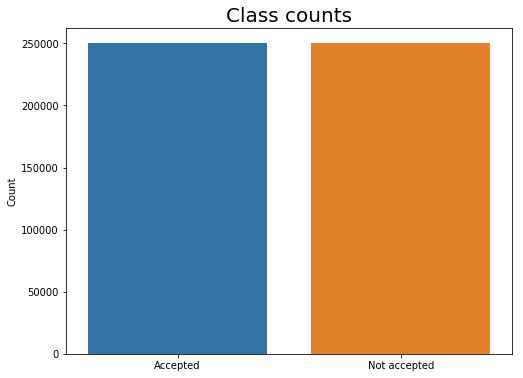

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(raw_df["accepted"])
plt.xticks((0, 1), ["Accepted", "Not accepted"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});

In [15]:
raw_df.isnull().sum()

loan_type                             0
property_type                         0
loan_purpose                          0
occupancy                             0
loan_amount                           0
preapproval                           0
msa_md                                0
state_code                            0
county_code                           0
applicant_ethnicity                   0
applicant_race                        0
applicant_sex                         0
applicant_income                  39948
population                        22465
minority_population_pct           22466
ffiecmedian_family_income         22440
tract_to_msa_md_income_pct        22514
number_of_owner-occupied_units    22565
number_of_1_to_4_family_units     22530
lender                                0
co_applicant                          0
accepted                              0
dtype: int64

In [16]:
#Imputing Missing values with mean for continuous variable
raw_df['applicant_income'].fillna(raw_df['applicant_income'].median(), inplace=True)
raw_df['population'].fillna(raw_df['population'].median(), inplace=True)
raw_df['minority_population_pct'].fillna(raw_df['minority_population_pct'].median(), inplace=True)
raw_df['ffiecmedian_family_income'].fillna(raw_df['ffiecmedian_family_income'].median(), inplace=True)
raw_df['tract_to_msa_md_income_pct'].fillna(raw_df['tract_to_msa_md_income_pct'].median(), inplace=True)
raw_df['number_of_owner-occupied_units'].fillna(raw_df['number_of_owner-occupied_units'].median(), inplace=True)
raw_df['number_of_1_to_4_family_units'].fillna(raw_df['number_of_1_to_4_family_units'].median(), inplace=True)
raw_df['msa_md'].fillna(raw_df['msa_md'].median(), inplace=True)
raw_df['state_code'].fillna(raw_df['state_code'].median(), inplace=True)
raw_df['county_code'].fillna(raw_df['county_code'].median(), inplace=True)
raw_df['lender'].fillna(raw_df['lender'].median(), inplace=True)

In [17]:
raw_df[raw_df['county_code']== -1]

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
26,1,1,1,1,113.000,1,-1,-1,-1,2,...,54.000,4975.000,22.901,67526.000,100.000,1327.000,1753.000,2839,False,0
38,1,1,1,2,88.000,1,-1,-1,-1,2,...,104.000,4975.000,22.901,67526.000,100.000,1327.000,1753.000,788,True,0
58,1,1,1,1,68.000,3,-1,48,-1,2,...,19.000,4975.000,22.901,67526.000,100.000,1327.000,1753.000,2654,False,0
79,2,1,1,1,296.000,1,-1,-1,-1,3,...,42.000,4975.000,22.901,67526.000,100.000,1327.000,1753.000,3060,False,0
90,2,1,1,1,64.000,1,-1,-1,-1,2,...,42.000,4975.000,22.901,67526.000,100.000,1327.000,1753.000,5415,True,0
99,1,1,1,1,139.000,1,-1,-1,-1,3,...,96.000,4975.000,22.901,67526.000,100.000,1327.000,1753.000,6349,False,0
120,1,2,1,1,410.000,3,-1,-1,-1,2,...,78.000,4975.000,22.901,67526.000,100.000,1327.000,1753.000,4390,False,0
123,1,1,1,1,40.000,1,-1,-1,-1,1,...,122.000,4975.000,22.901,67526.000,100.000,1327.000,1753.000,4701,True,0
129,1,1,1,1,136.000,1,-1,-1,-1,2,...,49.000,4975.000,22.901,67526.000,100.000,1327.000,1753.000,1495,False,0
158,1,1,1,1,168.000,1,-1,-1,-1,2,...,39.000,4975.000,22.901,67526.000,100.000,1327.000,1753.000,4701,False,0


In [18]:
raw_df.isnull().sum()

loan_type                         0
property_type                     0
loan_purpose                      0
occupancy                         0
loan_amount                       0
preapproval                       0
msa_md                            0
state_code                        0
county_code                       0
applicant_ethnicity               0
applicant_race                    0
applicant_sex                     0
applicant_income                  0
population                        0
minority_population_pct           0
ffiecmedian_family_income         0
tract_to_msa_md_income_pct        0
number_of_owner-occupied_units    0
number_of_1_to_4_family_units     0
lender                            0
co_applicant                      0
accepted                          0
dtype: int64

In [19]:
raw_df.describe()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,accepted
count,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,...,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000
mean,1.366,1.048,2.067,1.110,221.753,2.765,181.607,23.727,144.542,2.036,...,1.462,100.121,5396.982,31.226,69158.876,92.200,1423.173,1880.147,3720.121,0.500
std,0.691,0.231,0.948,0.326,590.642,0.543,138.464,15.983,100.244,0.511,...,0.678,147.474,2667.723,25.799,14478.233,13.990,721.028,893.718,1838.313,0.500
min,1.000,1.000,1.000,1.000,1.000,1.000,-1.000,-1.000,-1.000,1.000,...,1.000,1.000,14.000,0.534,17858.000,3.981,4.000,1.000,0.000,0.000
25%,1.000,1.000,1.000,1.000,93.000,3.000,25.000,6.000,57.000,2.000,...,1.000,49.000,3805.000,11.191,60071.000,89.145,963.000,1323.000,2442.000,0.000
50%,1.000,1.000,2.000,1.000,162.000,3.000,192.000,26.000,131.000,2.000,...,1.000,74.000,4975.000,22.901,67526.000,100.000,1327.000,1753.000,3731.000,1.000
75%,2.000,1.000,3.000,1.000,266.000,3.000,314.000,37.000,246.000,2.000,...,2.000,112.000,6379.000,44.486,74714.250,100.000,1754.000,2275.000,5436.000,1.000
max,4.000,3.000,3.000,3.000,100878.000,3.000,408.000,52.000,324.000,4.000,...,4.000,10139.000,37097.000,100.000,125248.000,100.000,8771.000,13623.000,6508.000,1.000


### 1.2 Answers to DAT102x: edX questions

The following statistics and visualizations are to answer questions answered on edX for this capstone project.

#### 1.2.1 Calculate Statistics of Loan Amount

In [20]:
# Loan Amount of the Data
loan_amount = raw_df['loan_amount']

# Minimum loan amount of the data
minimum_loan_amount = np.amin(loan_amount)

# Maximum loan amount of the data
maximum_loan_amount = np.amax(loan_amount)

# Mean loan amount of the data
mean_loan_amount = np.mean(loan_amount)

# Median loan amount of the data
median_loan_amount = np.median(loan_amount)

# Standard deviation of loan amount of the data
std_loan_amount = np.std(loan_amount)

# Show the calculated statistics
print("Statistics for Home mortgage dataset:\n")
print("Minimum loan amount: ${}".format(minimum_loan_amount)) 
print("Maximum loan amount: ${}".format(maximum_loan_amount))
print("Mean loan amount: ${}".format(mean_loan_amount))
print("Median loan amount ${}".format(median_loan_amount))
print("Standard deviation of loan amount: ${}".format(std_loan_amount))

Statistics for Home mortgage dataset:

Minimum loan amount: $1.0
Maximum loan amount: $100878.0
Mean loan amount: $221.753158
Median loan amount $162.0
Standard deviation of loan amount: $590.6410575459873


#### 1.2.2 Distribution of loan amount

In [21]:
df_sample = raw_df.sample(n=10000)

Text(0.5,0,'Loan Amount')

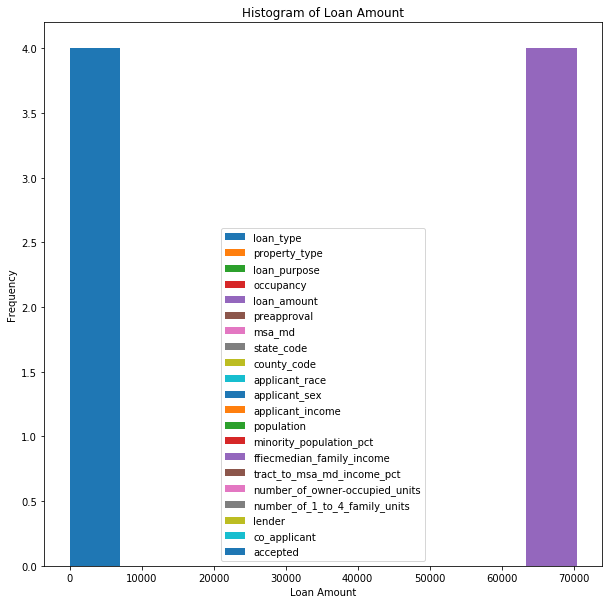

In [22]:
raw_df.groupby(['applicant_ethnicity']).mean().plot(kind='hist', title='Histogram of Loan Amount', label='Loan Amount', figsize = (10,10))
plt.xlabel('Loan Amount')

Text(0.5,0,'Loan Amount')

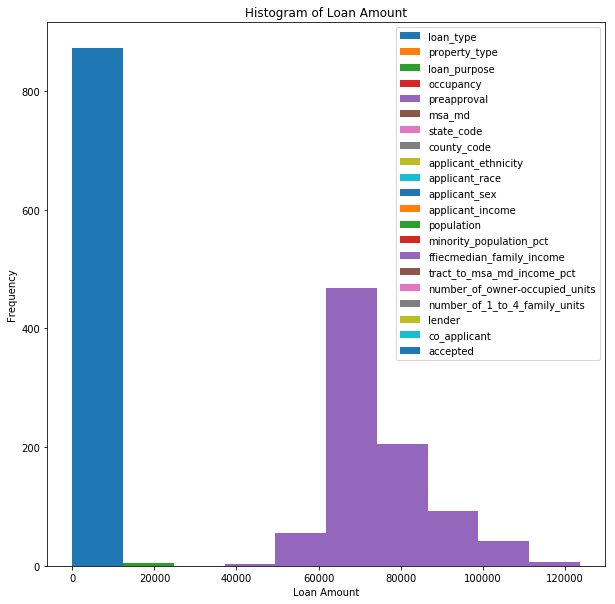

In [23]:
df_sample.groupby(['loan_amount']).mean().plot(kind='hist', title='Histogram of Loan Amount', label='Loan Amount', figsize = (10,10))
plt.xlabel('Loan Amount')

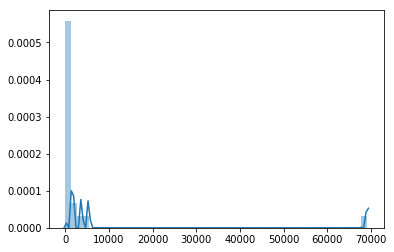

In [24]:
sns.distplot(raw_df.mean())

In [25]:
# Mean loan acceptance rate of the data
loan_acceptance_rate = raw_df['accepted']
mean_loan_acceptance_rate = np.mean(loan_acceptance_rate)
print("Mean loan acceptance rate: ${}".format(mean_loan_acceptance_rate))

Mean loan acceptance rate: $0.500228


In [26]:
# Loan acceptance rates across ethnicity and gender
#Applicants where applicant_ethnicity=4 have a higher loan acceptance rate on average than where applicant_ethnicity=1.
applicant__ethnicity_4 = raw_df[raw_df['applicant_ethnicity'] == 4]
applicant__ethnicity_4.describe()

# Ans: Applicants where applicant_ethnicity=4 have a higher loan acceptance rate on average than where applicant_ethnicity=1.

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,accepted
count,5819.000,5819.000,5819.000,5819.000,5819.000,5819.000,5819.000,5819.000,5819.000,5819.000,...,5819.000,5819.000,5819.000,5819.000,5819.000,5819.000,5819.000,5819.000,5819.000,5819.000
mean,1.018,1.549,1.894,2.164,1315.559,2.945,188.009,25.178,151.412,4.000,...,3.927,78.047,4828.984,37.122,68494.521,83.786,1105.348,1612.966,3320.282,0.789
std,0.167,0.884,0.956,0.520,4967.641,0.247,134.634,15.869,101.453,0.000,...,0.434,92.477,2173.893,29.060,12961.235,20.512,670.180,839.722,1876.716,0.408
min,1.000,1.000,1.000,1.000,1.000,1.000,-1.000,-1.000,-1.000,4.000,...,1.000,6.000,123.000,1.238,26396.000,3.981,4.000,6.000,6.000,0.000
25%,1.000,1.000,1.000,2.000,87.000,3.000,44.000,9.000,60.000,4.000,...,4.000,74.000,3364.500,13.404,60203.000,69.671,608.500,1058.000,1780.000,1.000
50%,1.000,1.000,1.000,2.000,196.000,3.000,200.000,26.000,134.000,4.000,...,4.000,74.000,4570.000,26.923,67564.000,94.928,1030.000,1532.000,3393.000,1.000
75%,1.000,3.000,3.000,2.000,661.000,3.000,312.000,38.000,250.000,4.000,...,4.000,74.000,5900.500,56.794,73757.000,100.000,1484.000,2057.000,5003.000,1.000
max,4.000,3.000,3.000,3.000,100878.000,3.000,408.000,52.000,322.000,4.000,...,4.000,5997.000,29596.000,100.000,123418.000,100.000,6046.000,6814.000,6508.000,1.000


In [27]:
#Applicants where applicant_ethnicity=4 have a lower loan acceptance rate on average than where applicant_ethnicity=1
applicant__ethnicity_1 = raw_df[raw_df['applicant_ethnicity'] == 1]
applicant__ethnicity_1.describe()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,accepted
count,50822.000,50822.000,50822.000,50822.000,50822.000,50822.000,50822.000,50822.000,50822.000,50822.000,...,50822.000,50822.000,50822.000,50822.000,50822.000,50822.000,50822.000,50822.000,50822.000,50822.000
mean,1.428,1.043,2.006,1.083,177.651,2.763,189.793,23.721,143.321,1.000,...,1.315,76.034,5787.591,56.405,64624.652,87.487,1307.279,1787.269,3712.435,0.427
std,0.662,0.207,0.939,0.279,146.300,0.544,139.784,17.423,99.942,0.000,...,0.473,93.751,2897.031,28.923,16642.473,17.063,727.299,904.009,1861.479,0.495
min,1.000,1.000,1.000,1.000,1.000,1.000,-1.000,-1.000,-1.000,1.000,...,1.000,1.000,14.000,1.284,17858.000,13.172,6.000,1.000,8.000,0.000
25%,1.000,1.000,1.000,1.000,85.000,3.000,25.000,6.000,56.000,1.000,...,1.000,40.000,4110.000,29.691,57943.500,76.916,841.000,1224.000,2442.000,0.000
50%,1.000,1.000,2.000,1.000,149.500,3.000,205.000,28.000,131.000,1.000,...,1.000,63.000,5170.000,56.906,63903.000,100.000,1220.000,1675.000,3534.000,0.000
75%,2.000,1.000,3.000,1.000,239.000,3.000,324.000,37.000,246.000,1.000,...,2.000,86.000,6745.000,83.358,71772.000,100.000,1608.000,2137.000,5473.000,1.000
max,4.000,3.000,3.000,3.000,6021.000,3.000,408.000,52.000,324.000,1.000,...,4.000,9899.000,34171.000,100.000,125206.000,100.000,8738.000,13494.000,6503.000,1.000


In [28]:
#Applicants where applicant_sex=1 have a lower loan acceptance rate on average than where applicant_sex=2
applicant_sex_1 = raw_df[raw_df['applicant_sex'] == 1]
applicant_sex_1.describe()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,accepted
count,315806.000,315806.000,315806.000,315806.000,315806.000,315806.000,315806.000,315806.000,315806.000,315806.000,...,315806.000,315806.000,315806.000,315806.000,315806.000,315806.000,315806.000,315806.000,315806.000,315806.000
mean,1.402,1.038,2.064,1.103,223.468,2.762,181.378,23.798,144.864,1.938,...,1.000,108.454,5440.822,30.051,69038.277,92.785,1440.923,1898.742,3699.730,0.521
std,0.730,0.197,0.955,0.309,227.266,0.543,138.713,15.963,100.138,0.395,...,0.000,159.329,2714.473,25.178,14406.132,13.406,727.088,903.693,1837.880,0.500
min,1.000,1.000,1.000,1.000,1.000,1.000,-1.000,-1.000,-1.000,1.000,...,1.000,1.000,14.000,0.534,17858.000,6.305,4.000,1.000,1.000,0.000
25%,1.000,1.000,1.000,1.000,102.000,3.000,25.000,6.000,57.000,2.000,...,1.000,53.000,3826.000,10.611,59973.000,90.615,979.000,1336.000,2442.000,0.000
50%,1.000,1.000,2.000,1.000,174.000,3.000,192.000,26.000,131.000,2.000,...,1.000,75.000,4975.000,22.901,67526.000,100.000,1327.000,1753.000,3617.000,1.000
75%,2.000,1.000,3.000,1.000,281.000,3.000,314.000,37.000,246.000,2.000,...,1.000,121.000,6430.000,42.333,74591.000,100.000,1772.000,2298.000,5367.000,1.000
max,4.000,3.000,3.000,3.000,15983.000,3.000,408.000,52.000,324.000,4.000,...,1.000,10106.000,37097.000,100.000,125248.000,100.000,8771.000,13623.000,6507.000,1.000


In [29]:
#Applicants where applicant_sex=1 have a higher loan acceptance rate on average than where applicant_sex=2.
applicant_sex_2 = raw_df[raw_df['applicant_sex'] == 2]
applicant_sex_2.mean()

# Ans: Applicants where applicant_sex=1 have a higher loan acceptance rate on average than where applicant_sex=2

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,accepted
count,142876.000,142876.000,142876.000,142876.000,142876.000,142876.000,142876.000,142876.000,142876.000,142876.000,...,142876.000,142876.000,142876.000,142876.000,142876.000,142876.000,142876.000,142876.000,142876.000,142876.000
mean,1.311,1.050,2.038,1.082,172.447,2.759,181.281,23.546,143.508,1.945,...,2.000,79.517,5322.933,33.370,69046.367,91.177,1398.110,1854.331,3721.487,0.466
std,0.612,0.220,0.938,0.278,163.654,0.550,137.949,16.048,100.232,0.402,...,0.000,101.338,2574.343,26.915,14591.878,14.742,706.545,870.884,1829.292,0.499
min,1.000,1.000,1.000,1.000,1.000,1.000,-1.000,-1.000,-1.000,1.000,...,2.000,1.000,19.000,0.669,17862.000,6.234,6.000,1.000,0.000,0.000
25%,1.000,1.000,1.000,1.000,77.000,3.000,25.000,6.000,57.000,2.000,...,2.000,40.000,3772.000,12.143,60059.000,86.357,943.000,1308.000,2442.000,0.000
50%,1.000,1.000,2.000,1.000,138.000,3.000,192.000,25.000,131.000,2.000,...,2.000,64.000,4975.000,23.300,67526.000,100.000,1327.000,1753.000,3643.000,0.000
75%,1.000,1.000,3.000,1.000,225.000,3.000,314.000,37.000,246.000,2.000,...,2.000,92.000,6296.000,48.569,74622.000,100.000,1724.250,2240.000,5418.000,1.000
max,4.000,3.000,3.000,3.000,15025.000,3.000,408.000,52.000,324.000,4.000,...,2.000,10139.000,34167.000,100.000,125206.000,100.000,8764.000,13537.000,6506.000,1.000


In [30]:
# Applicant income and loan amount
# For applicants in state 45 , which of the following best describes the relationship between applicant income and loan amount?
applicant__state_code = raw_df[raw_df['state_code'] == 45]
applicant__state_code.describe()

# Ans: A higher applicant income is associated with a higher loan amount, on average.

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,accepted
count,4638.000,4638.000,4638.000,4638.000,4638.000,4638.000,4638.000,4638.000,4638.000,4638.000,...,4638.000,4638.000,4638.000,4638.000,4638.000,4638.000,4638.000,4638.000,4638.000,4638.000
mean,1.302,1.016,2.187,1.087,267.672,2.806,212.744,45.000,118.762,2.060,...,1.487,123.492,4956.273,22.624,91216.154,90.670,1437.877,1743.117,3632.300,0.505
std,0.599,0.165,0.931,0.301,570.228,0.440,83.538,0.000,73.038,0.472,...,0.679,178.349,1579.213,21.712,10540.053,16.730,566.627,581.926,1773.125,0.500
min,1.000,1.000,1.000,1.000,2.000,1.000,-1.000,45.000,-1.000,1.000,...,1.000,1.000,1265.000,2.960,67526.000,15.522,17.000,198.000,18.000,0.000
25%,1.000,1.000,1.000,1.000,122.000,3.000,132.000,45.000,55.000,2.000,...,1.000,59.250,3762.250,8.063,83143.000,87.224,1079.250,1333.250,2371.000,0.000
50%,1.000,1.000,3.000,1.000,192.000,3.000,274.000,45.000,133.000,2.000,...,1.000,80.000,4858.500,13.118,87432.500,100.000,1403.000,1695.000,3497.000,1.000
75%,1.000,1.000,3.000,1.000,291.000,3.000,276.000,45.000,165.000,2.000,...,2.000,130.000,5988.750,27.956,104869.750,100.000,1791.750,2104.750,5381.000,1.000
max,4.000,3.000,3.000,3.000,32647.000,3.000,276.000,45.000,203.000,4.000,...,4.000,3601.000,9553.000,100.000,110720.000,100.000,3076.000,3342.000,6468.000,1.000


In [31]:
# Loan acceptance across counties
# Limiting just to state 48 and ignoring where county is missing (missing value being -1), which of the following statements is true?
applicant__state_code = raw_df[raw_df['state_code'] == 48]
applicant__state_code.describe()
# Ans: In state 48, the average rate of loan acceptance across counties varies substantially, ranging from around 30% to arround 70%

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,accepted
count,15761.000,15761.000,15761.000,15761.000,15761.000,15761.000,15761.000,15761.000,15761.000,15761.000,...,15761.000,15761.000,15761.000,15761.000,15761.000,15761.000,15761.000,15761.000,15761.000,15761.000
mean,1.245,1.049,2.000,1.128,323.591,2.802,231.307,48.000,162.378,2.086,...,1.510,130.465,4727.337,29.580,77897.999,90.947,1204.028,1521.420,3625.498,0.486
std,0.550,0.270,0.924,0.373,1013.661,0.455,106.664,0.000,102.116,0.499,...,0.715,276.324,1861.912,29.360,16150.219,15.381,613.950,797.627,1816.417,0.500
min,1.000,1.000,1.000,1.000,1.000,1.000,-1.000,48.000,-1.000,1.000,...,1.000,1.000,19.000,1.200,55499.000,8.557,7.000,6.000,38.000,0.000
25%,1.000,1.000,1.000,1.000,89.000,3.000,108.000,48.000,72.000,2.000,...,1.000,57.000,3441.000,7.642,69198.000,86.659,723.000,966.000,2193.000,0.000
50%,1.000,1.000,2.000,1.000,195.000,3.000,267.000,48.000,137.000,2.000,...,1.000,79.000,4549.000,17.407,71177.000,100.000,1193.000,1524.000,3449.000,0.000
75%,1.000,1.000,3.000,1.000,355.000,3.000,314.000,48.000,251.000,2.000,...,2.000,128.000,5878.000,39.908,82344.000,100.000,1641.000,2014.000,5316.000,1.000
max,4.000,3.000,3.000,3.000,44419.000,3.000,394.000,48.000,321.000,4.000,...,4.000,10139.000,26953.000,100.000,112268.000,100.000,6340.000,6525.000,6481.000,1.000


In [32]:
# Looking just at states 2 and 4, which of the following statements is true?
applicant__state_code_2 = raw_df[raw_df['state_code'] == 2]
applicant__state_code_2.describe()
# Looking just at states 2 and 4, which of the following statements is true?
applicant__state_code_4 = raw_df[raw_df['state_code'] == 4]
applicant__state_code_4.describe()
#Ans: For each of the four loan types, the loan acceptance rate in state 2 is lower than for the corrsponding loan type in state

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,accepted
count,12858.000,12858.000,12858.000,12858.000,12858.000,12858.000,12858.000,12858.000,12858.000,12858.000,...,12858.000,12858.000,12858.000,12858.000,12858.000,12858.000,12858.000,12858.000,12858.000,12858.000
mean,1.382,1.051,2.132,1.111,276.840,2.786,194.409,4.000,192.853,2.099,...,1.450,104.272,5281.281,24.945,76670.290,91.893,1388.199,1827.272,3646.661,0.575
std,0.711,0.242,0.959,0.329,895.947,0.486,118.484,0.000,82.005,0.455,...,0.684,108.452,1667.689,15.645,12087.626,13.406,508.977,687.146,1854.486,0.494
min,1.000,1.000,1.000,1.000,1.000,1.000,-1.000,4.000,-1.000,1.000,...,1.000,1.000,703.000,4.803,51604.000,14.275,14.000,26.000,17.000,0.000
25%,1.000,1.000,1.000,1.000,151.000,3.000,114.000,4.000,137.000,2.000,...,1.000,58.000,4123.250,13.206,68336.500,87.513,1028.000,1396.000,2349.000,0.000
50%,1.000,1.000,3.000,1.000,225.000,3.000,286.000,4.000,210.000,2.000,...,1.000,79.000,5147.000,20.675,73453.000,100.000,1360.000,1740.000,3354.000,1.000
75%,2.000,1.000,3.000,1.000,326.000,3.000,286.000,4.000,233.000,2.000,...,2.000,122.000,6337.000,32.404,89061.750,100.000,1715.750,2186.000,5710.000,1.000
max,4.000,3.000,3.000,3.000,92592.000,3.000,377.000,4.000,321.000,4.000,...,4.000,5840.000,13339.000,97.152,92286.000,100.000,3086.000,5986.000,6463.000,1.000


### 1.3. Explorer the Features: 

In [33]:
raw_df.dtypes

loan_type                           int64
property_type                       int64
loan_purpose                        int64
occupancy                           int64
loan_amount                       float64
preapproval                         int64
msa_md                              int64
state_code                          int64
county_code                         int64
applicant_ethnicity                 int64
applicant_race                      int64
applicant_sex                       int64
applicant_income                  float64
population                        float64
minority_population_pct           float64
ffiecmedian_family_income         float64
tract_to_msa_md_income_pct        float64
number_of_owner-occupied_units    float64
number_of_1_to_4_family_units     float64
lender                              int64
co_applicant                         bool
accepted                            int64
dtype: object

#### 1.3.2. Explorer the target variable: 

In [34]:
raw_df['accepted'].describe()

count   500000.000
mean         0.500
std          0.500
min          0.000
25%          0.000
50%          1.000
75%          1.000
max          1.000
Name: accepted, dtype: float64

In [35]:
(raw_df['accepted']==0).value_counts()

False    250114
True     249886
Name: accepted, dtype: int64

In [36]:
(raw_df['accepted']==1).value_counts()

True     250114
False    249886
Name: accepted, dtype: int64

In [37]:
raw_df['accepted'].isnull().values.any()

False

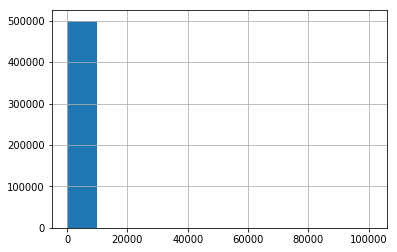

In [38]:
count, division = np.histogram(raw_df['loan_amount'])
raw_df['loan_amount'].hist(bins=division)

Text(0.5,0,'accepted')

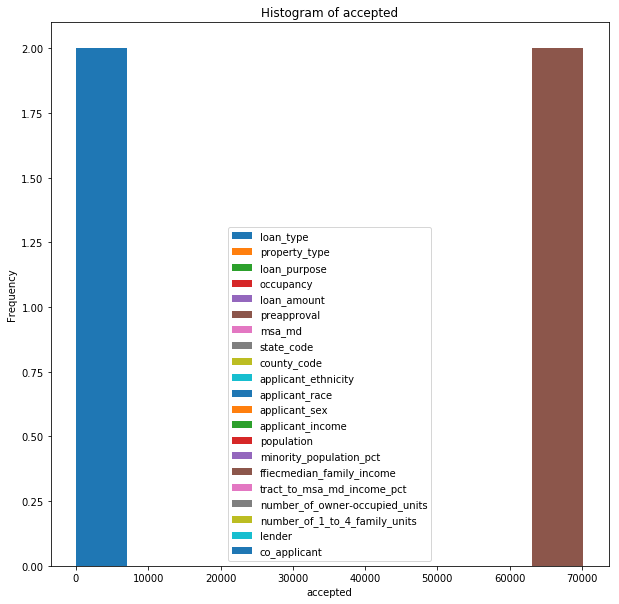

In [39]:
raw_df.groupby(['accepted']).mean().plot(kind='hist', title='Histogram of accepted', label='accepted', figsize = (10,10))
plt.xlabel('accepted')

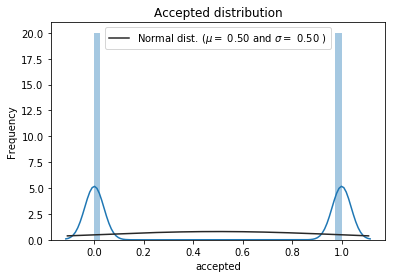

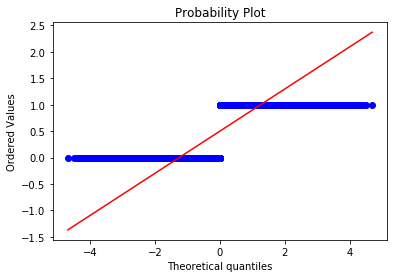

In [40]:
(mu, sigma) = ss.norm.fit(raw_df['accepted'])
sns.distplot(raw_df['accepted'], fit=ss.norm);

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Accepted distribution')

fig = plt.figure()
res = ss.probplot(raw_df['accepted'], plot=plt)
plt.show()

### 1.4. Plot Raw data

In [41]:
# To see and get number columns
# Convert all non-numeric values to number
raw_num_cols =(raw_df.dtypes == float) | (raw_df.dtypes==np.int64)
raw_num_cols = [c for c in raw_num_cols.index if raw_num_cols[c]]
raw_num_cols

['loan_type',
 'property_type',
 'loan_purpose',
 'occupancy',
 'loan_amount',
 'preapproval',
 'msa_md',
 'state_code',
 'county_code',
 'applicant_ethnicity',
 'applicant_race',
 'applicant_sex',
 'applicant_income',
 'population',
 'minority_population_pct',
 'ffiecmedian_family_income',
 'tract_to_msa_md_income_pct',
 'number_of_owner-occupied_units',
 'number_of_1_to_4_family_units',
 'lender',
 'accepted']

In [42]:
raw_df.head()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
0,3,1,1,1,70.000,3,18,37,246,2,...,24.000,6203.000,44.230,60588.000,50.933,716.000,2642.000,4536,False,1
1,1,1,3,1,178.000,3,369,52,299,1,...,57.000,5774.000,15.905,54821.000,100.000,1622.000,2108.000,2458,False,0
2,2,1,3,1,163.000,3,16,10,306,2,...,67.000,6094.000,61.270,67719.000,100.000,760.000,1048.000,5710,False,1
3,1,1,1,1,155.000,1,305,47,180,2,...,105.000,6667.000,6.246,78439.000,100.000,2025.000,2299.000,5888,True,1
4,1,1,1,1,305.000,3,24,37,20,2,...,71.000,6732.000,100.000,63075.000,82.200,1464.000,1847.000,289,False,1


Text(0.5,1,'Correlation Heatmap of Numeric Features')

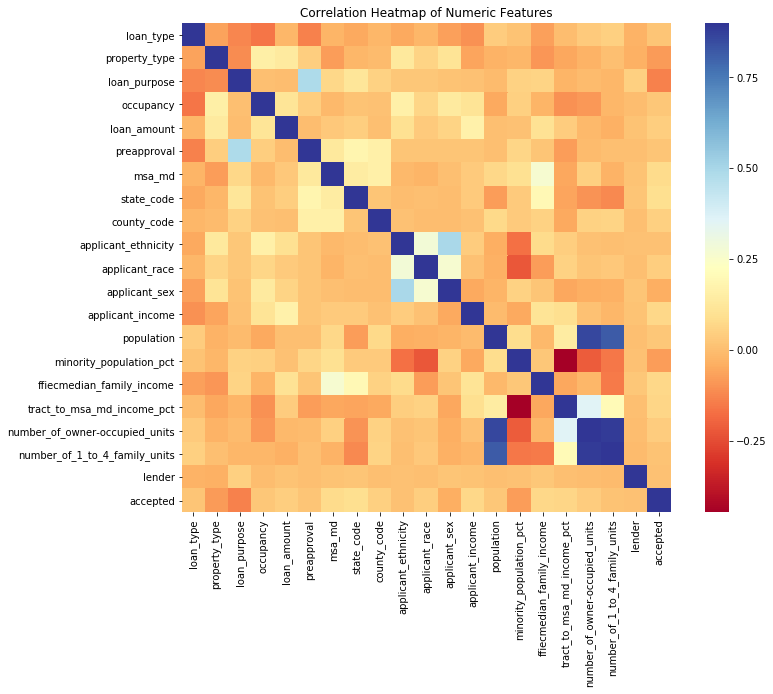

In [43]:
corrmat = raw_df[raw_num_cols].corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True,cmap="RdYlBu")
plt.title('Correlation Heatmap of Numeric Features')

### 1.5. Explorer features

In [44]:
raw_df.columns

Index(['loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'lender', 'co_applicant', 'accepted'],
      dtype='object')

In [45]:
PROPERTY_LOCATION_COLS = ['msa_md', 'state_code', 'county_code']

LOAN_INFORMATION_COLS = ['lender', 'loan_amount', 'loan_type',
                         'property_type', 'loan_purpose', 
                         'occupancy', 'preapproval']

APPLICANT_INFORMATION_COLS = ['applicant_income', 'applicant_ethnicity', 
                              'applicant_race', 'applicant_sex', 
                              'co_applicant']
CENSUS_INFORMATION_COLS = ['population', 'minority_population_pct', 'ffiecmedian_family_income', 
                           'tract_to_msa_md_income_pct', 'number_of_owner-occupied_units', 
                           'number_of_1_to_4_family_units']



#### Pair grid of key variables.

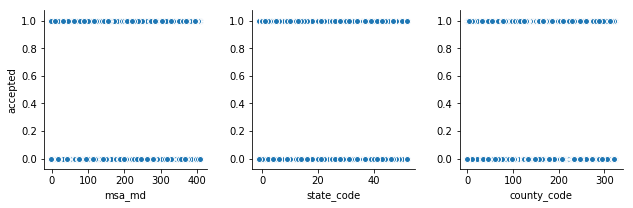

In [46]:
sns.pairplot(raw_df,
             y_vars= ['accepted'],
             x_vars=PROPERTY_LOCATION_COLS,
             size=3)

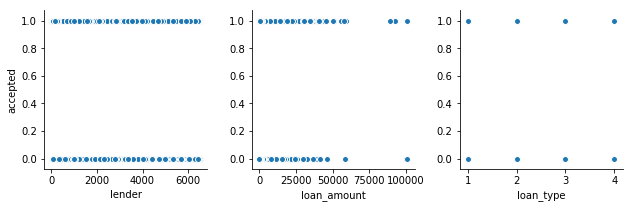

In [47]:
sns.pairplot(raw_df,
             y_vars= ['accepted'],
             x_vars=LOAN_INFORMATION_COLS[:3],
             size=3)

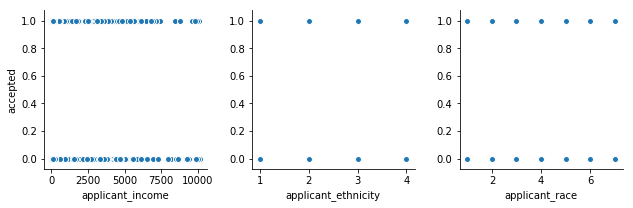

In [48]:
sns.pairplot(raw_df,
             y_vars= ['accepted'],
             x_vars=APPLICANT_INFORMATION_COLS[:3],
             size=3)

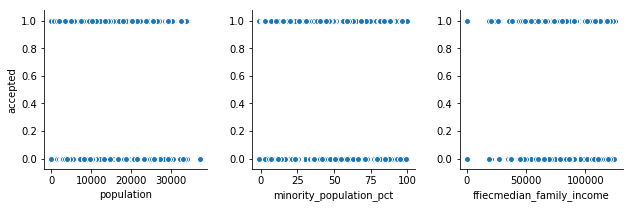

In [105]:
sns.pairplot(raw_df,
             y_vars= ['accepted'],
             x_vars=CENSUS_INFORMATION_COLS[:3],
             size=3)

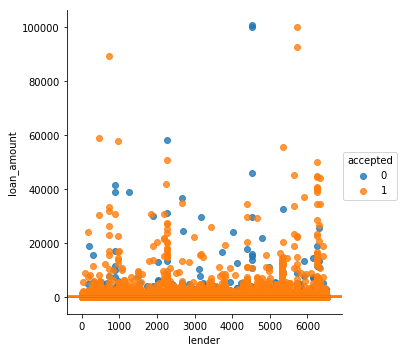

In [106]:
sns.lmplot(x="lender", y="loan_amount", hue="accepted", data=raw_df)

# 2. Data Cleaning

In [114]:
# Great, no missing values
# Now Some more data munging
# The variables loan amount and Applicant Income have outliers and in this problem it is normal to have higher income
#and so applying for higher amount of loan is possible.Take log transformation to have a normal distribution

In [115]:
# search missing data in num df
available_data = raw_df.notnull().apply(pd.Series.value_counts).T
available_data.columns = ['A']
not_available_data= available_data[available_data['A']>=0]
not_available_data

,A
loan_type,500000
property_type,500000
loan_purpose,500000
occupancy,500000
loan_amount,500000
preapproval,500000
msa_md,500000
state_code,500000
county_code,500000
applicant_ethnicity,500000


In [116]:
#raw_df['loan_amount_log'] = np.log(raw_df['loan_amount'])

In [117]:
#we can conclude, there are not a strog correlations to loss data
df_clean = raw_df
df_clean.shape

(500000, 22)

In [118]:
df_clean.describe()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,accepted
count,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,...,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000
mean,1.366,1.048,2.067,1.110,221.753,2.765,181.607,23.727,144.542,2.036,...,1.462,94.129,5173.411,30.152,66128.265,87.653,1363.240,1801.112,3720.121,0.500
std,0.691,0.231,0.948,0.326,590.642,0.543,138.464,15.983,100.244,0.511,...,0.678,149.918,2892.740,26.608,20371.067,23.737,779.363,975.301,1838.313,0.500
min,1.000,1.000,1.000,1.000,1.000,1.000,-1.000,-1.000,-1.000,1.000,...,1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.000,0.000
25%,1.000,1.000,1.000,1.000,93.000,3.000,25.000,6.000,57.000,2.000,...,1.000,40.000,3557.000,9.308,58637.000,84.654,884.000,1229.000,2442.000,0.000
50%,1.000,1.000,2.000,1.000,162.000,3.000,192.000,26.000,131.000,2.000,...,1.000,68.000,4854.000,21.412,66362.000,100.000,1291.000,1709.000,3731.000,1.000
75%,2.000,1.000,3.000,1.000,266.000,3.000,314.000,37.000,246.000,2.000,...,2.000,112.000,6379.000,44.486,74714.250,100.000,1754.000,2275.000,5436.000,1.000
max,4.000,3.000,3.000,3.000,100878.000,3.000,408.000,52.000,324.000,4.000,...,4.000,10139.000,37097.000,100.000,125248.000,100.000,8771.000,13623.000,6508.000,1.000


In [119]:
df_clean.isnull().sum()

loan_type                         0
property_type                     0
loan_purpose                      0
occupancy                         0
loan_amount                       0
preapproval                       0
msa_md                            0
state_code                        0
county_code                       0
applicant_ethnicity               0
applicant_race                    0
applicant_sex                     0
applicant_income                  0
population                        0
minority_population_pct           0
ffiecmedian_family_income         0
tract_to_msa_md_income_pct        0
number_of_owner-occupied_units    0
number_of_1_to_4_family_units     0
lender                            0
co_applicant                      0
accepted                          0
dtype: int64

In [120]:
df_clean.isnull().sum().sum()

0

#### Remove outliers

Outliers no applied because there aren't strong linear relation

### 2.1.  Explorer Clean DF Interesting feature

In [ ]:
int_cols = (['loan_type','lender','loan_amount','preapproval', 'property_type'])

In [ ]:
sns.pairplot(df_clean,
             vars=int_cols,
            size=3)

In [ ]:
corr = df_clean.loc[:,int_cols].corr()
sns.heatmap(corr,cmap="RdYlBu" )

In [ ]:
sns.pairplot(df_clean, y_vars=['accepted'],
                  x_vars= int_cols[:5],
            size=3)

###  2.2. Explorer Categorical feautured

Separe num colums and bool columns

In [ ]:
# To see and get number columns
category_num_cols =(df_clean.dtypes == float) | (df_clean.dtypes==np.int64)
raw_category_num_cols = [c for c in category_num_cols.index if category_num_cols[c]]
raw_category_num_cols

In [ ]:
# To see and get number columns
num =(raw_df.dtypes == bool)
raw_bool_cols = [c for c in num.index if num[c]]
raw_bool_cols

In [ ]:
corr = df_clean[raw_category_num_cols].corr()
#corr = df_clean.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='Blues')
plt.title('Correlation Heatmap of Numeric Features')

In [ ]:
#explorer categorical (number) columns 
df_clean[raw_category_num_cols].apply(pd.Series.nunique).sort_values()

In [ ]:
#explorer categorical (number) columns 
df_clean[raw_bool_cols].apply(pd.Series.nunique).sort_values()

In [ ]:
def count_unique(df, cols):
    for col in cols:
        print('\n' + 'For column ' + col)
        print(df[col].value_counts())
        
count_unique(df_clean,raw_category_num_cols)

In [ ]:
count_unique(df_clean,raw_bool_cols)

In [ ]:
sns.set_style("whitegrid")
sns.boxplot('co_applicant', 'accepted', data=df_clean)
plt.xlabel('co_applicant') # Set text for the x axis
plt.ylabel('accepted')# Set text for y axis
plt.show()

In [ ]:
sns.lmplot(x="preapproval", y="loan_type", hue="accepted", data=df_clean)

In [ ]:
df_clean[['lender', 'preapproval']].groupby(['preapproval']).mean().plot(kind='bar', title='Average lender by preapproval', color='xkcd:azure')
plt.xlabel('Preapproval')
plt.ylabel('Average Count of Lender')

In [ ]:
df_clean[['preapproval', 'loan_type']].groupby(['loan_type']).mean().plot(kind='bar', title='Average preapproval by loan_type', color='xkcd:azure')
plt.xlabel('Loan Type')
plt.ylabel('Average Count of Pre-approval')

#### Loan Type

well we can considered to transform a numercial 

In [ ]:
plt.hist(df_clean.loan_type)

In [ ]:
# Pair grid of key variables.
g = sns.FacetGrid(df_clean, col='accepted')
g.map(plt.hist, 'loan_type')

#### Applicant Race

In [ ]:
plt.hist(df_clean.applicant_race)

In [ ]:
# Pair grid of key variables.
g = sns.FacetGrid(df_clean, col='accepted')
g.map(plt.hist, 'applicant_race')

#### Lender

In [ ]:
plt.hist(df_clean.lender)

In [ ]:
# Pair grid of key variables.
g = sns.FacetGrid(df_clean, col='accepted')
g.map(plt.hist, 'lender')

### 3. Transforming

[https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621](Label Encoder vs. One Hot Encoder in Machine Learning)

#### Determinations

Many of the categorical variables have one category that by far the majority. One option to encode these features is one hot encoding, there a new binary feature will be made for each category in each feature. This is an excellent way of dealing with categorical data. However the curse of dimensionality causes our number of features to increase from 39 to 68.

Let's try both one hot encoding and feature hashing as a way of encoding these categorical variables.

#### One Hot Encoding of Categorical Features

The following features are categorical. For sklearn we will need to convert these to numeric feature:


* property_type            ** [int64] **
* loan_purpose             ** [int64] **
* loan_type                ** [int64] **
* occupancy                ** [int64] **
* preapproval              ** [int64] **
* applicant_ethnicity      ** [int64] **
* applicant_race           ** [int64] **
* applicant_sex            ** [int64] **
* lender                   ** [int64] **
* accepted                 ** [int64] **


The best way to do this is through one-hot encoding. We will use Pandas get_dummies method to accomplish this. Scikitlearn has a One_hot_encoding method as part of their preprocessing set as well.

### 3.1. Transform Bool cols

Label Encoder and One Hot Encoder. These two encoders are parts of the SciKit Learn library in Python, and they are used to convert categorical data, or text data, into numbers, which our predictive models can better understand. 

[Label Encoder vs. One Hot Encoder in Machine Learning](https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621)

In [64]:
print(df_clean['co_applicant'].unique())
def encode_string(cat_feature):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_feature)
    enc_cat_feature = enc.transform(cat_feature)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_feature.reshape(-1,1))
    return encoded.transform(enc_cat_feature.reshape(-1,1)).toarray()
    
categorical_columns= ['co_applicant']

for col in categorical_columns:
    temp = encode_string(df_clean[col])
    Features_co_applicant = np.concatenate([temp], axis = 1)
#explorer categorical (bool) columns 
enc_co_applicant = ['co_applicant_True', 'co_applicant_False']
print(Features_co_applicant.shape)
print(Features_co_applicant[:10, :])  


[False  True]
(500000, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [65]:
print(df_clean['loan_type'].unique())
categorical_columns= ['loan_type']
for col in categorical_columns:
    temp = encode_string(df_clean[col])
    Features_loan_type = np.concatenate([temp], axis = 1)
enc_loan_type = ['loan_type_conv','loan_type_FHA','loan_type_VA','loan_type_FSA_RHS']
print(Features_loan_type.shape)
print(Features_loan_type[:5, :]) 

[3 1 2 4]
(500000, 4)
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [66]:
print(df_clean['property_type'].unique())
categorical_columns= ['property_type']
for col in categorical_columns:
    temp = encode_string(df_clean[col])
    Features_property_type = np.concatenate([temp], axis = 1)
enc_property_type = ['property_type_One_to_four_family','property_type_Manufactured_housing', 'property_type_Multifamily']
print(Features_property_type.shape)
print(Features_property_type[:5, :]) 

[1 2 3]
(500000, 3)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [67]:
print(df_clean['loan_purpose'].unique())
categorical_columns= ['loan_purpose']
for col in categorical_columns:
    temp = encode_string(df_clean[col])
    Features_loan_purpose = np.concatenate([temp], axis = 1)
enc_loan_purpose = ['loan_purpose_Home_purchase','loan_purpose_Home_improvement','loan_purpose_Refinancing']
print(Features_loan_purpose.shape)
print(Features_loan_purpose[:5, :]) 

[1 3 2]
(500000, 3)
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [68]:
print(df_clean['occupancy'].unique())
categorical_columns= ['occupancy']
for col in categorical_columns:
    temp = encode_string(df_clean[col])
    Features_occupancy = np.concatenate([temp], axis = 1)
enc_occupancy = ['occupancy_Owner_occupied','occupancy_Not_owner_occupied','occupancy_Not_applicable']
print(Features_occupancy.shape)
print(Features_occupancy[:5, :]) 

[1 2 3]
(500000, 3)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [69]:
print(df_clean['preapproval'].unique())
categorical_columns= ['preapproval']
for col in categorical_columns:
    temp = encode_string(df_clean[col])
    Features_preapproval = np.concatenate([temp], axis = 1)
enc_preapproval = ['preapproval_Preapproval_requested','preapproval_Preapproval_not_requested','preapproval_Not_applicable']
print(Features_preapproval.shape)
print(Features_preapproval[:5, :]) 

[3 1 2]
(500000, 3)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [70]:
print(df_clean['applicant_ethnicity'].unique())
categorical_columns= ['applicant_ethnicity']
for col in categorical_columns:
    temp = encode_string(df_clean[col])
    Features_applicant_ethnicity = np.concatenate([temp], axis = 1)
enc_applicant_ethnicity = ['applicant_ethnicity_Hispanic_Latino',
           'applicant_ethnicity_Not_Hispanic_Latino','applicant_ethnicity_Information_not_provided',
           'applicant_ethnicity_Not_applicable']
print(Features_applicant_ethnicity.shape)
print(Features_applicant_ethnicity[:5, :]) 

[2 1 3 4]
(500000, 4)
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [71]:
print(df_clean['applicant_race'].unique())
categorical_columns= ['applicant_race']
for col in categorical_columns:
    temp = encode_string(df_clean[col])
    Features_applicant_race = np.concatenate([temp], axis = 1)
enc_applicant_race = ['applicant_race_American_Indian','applicant_race_Asian', 'applicant_race_African_American',
           'applicant_race_Native_Hawaiian','applicant_race_White','applicant_race_Information_not_provided',
           'applicant_race_Not_applicable']
print(Features_applicant_race.shape)
print(Features_applicant_race[:5, :]) 

[5 3 6 2 1 7 4]
(500000, 7)
[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]


In [72]:
print(df_clean['applicant_sex'].unique())
categorical_columns= ['applicant_sex']
for col in categorical_columns:
    temp = encode_string(df_clean[col])
    Features_applicant_sex = np.concatenate([temp], axis = 1)
enc_applicant_sex = ['applicant_sex_Male','applicant_sex_Female', 'applicant_sex_Information_not_provided',
                 'applicant_sex_Not_applicable']
print(Features_applicant_sex.shape)
print(Features_applicant_sex[:5, :]) 

[1 2 3 4]
(500000, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [73]:
df_clean.head()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
0,3,1,1,1,70.000,3,18,37,246,2,...,24.000,6203.000,44.230,60588.000,50.933,716.000,2642.000,4536,False,1
1,1,1,3,1,178.000,3,369,52,299,1,...,57.000,5774.000,15.905,54821.000,100.000,1622.000,2108.000,2458,False,0
2,2,1,3,1,163.000,3,16,10,306,2,...,67.000,6094.000,61.270,67719.000,100.000,760.000,1048.000,5710,False,1
3,1,1,1,1,155.000,1,305,47,180,2,...,105.000,6667.000,6.246,78439.000,100.000,2025.000,2299.000,5888,True,1
4,1,1,1,1,305.000,3,24,37,20,2,...,71.000,6732.000,100.000,63075.000,82.200,1464.000,1847.000,289,False,1


In [74]:
df_clean.dtypes

loan_type                           int64
property_type                       int64
loan_purpose                        int64
occupancy                           int64
loan_amount                       float64
preapproval                         int64
msa_md                              int64
state_code                          int64
county_code                         int64
applicant_ethnicity                 int64
applicant_race                      int64
applicant_sex                       int64
applicant_income                  float64
population                        float64
minority_population_pct           float64
ffiecmedian_family_income         float64
tract_to_msa_md_income_pct        float64
number_of_owner-occupied_units    float64
number_of_1_to_4_family_units     float64
lender                              int64
co_applicant                         bool
accepted                            int64
dtype: object

### 3.2. Transforming Categorical Data
[Categorical Data](https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63)

In [104]:
#df_clean['loan_amount_log'] = np.log((1 + df_clean['loan_amount']))
df_clean['loan_amount_log'] = np.log((df_clean['loan_amount']))
#df_clean['loan_amount_log'] = np.round(df_clean['loan_amount_log'])
df_clean['applicant_income_log'] = np.log((df_clean['applicant_income']))
#df_clean['applicant_income_log'] = np.round(df_clean['applicant_income_log'])

NameError: name 'df_clean' is not defined

Text(11.5,450,'$\\mu$=4.94')

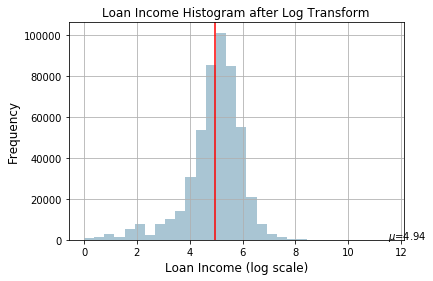

In [76]:
loan_income_log_mean = np.round(np.mean(df_clean['loan_amount_log']), 2)
fig, ax = plt.subplots()
df_clean['loan_amount_log'].hist(bins=30, color='#A9C5D3')
plt.axvline(loan_income_log_mean, color='r')
ax.set_title('Loan Income Histogram after Log Transform', fontsize=12)
ax.set_xlabel('Loan Income (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(11.5, 450, r'$\mu$='+str(loan_income_log_mean), fontsize=10)


In [77]:
df_clean['msa_md_log'] = np.log((df_clean['msa_md']))
#df_clean['msa_md_log'] = np.round(df_clean['msa_md_log'])

In [78]:
df_clean['ffiecmedian_family_income_log'] = np.log((df_clean['ffiecmedian_family_income']))
#df_clean['ffiecmedian_family_income_log'] = np.round(df_clean['ffiecmedian_family_income_log'])

In [79]:
df_clean['tract_to_msa_md_income_pct_log'] = np.log((df_clean['tract_to_msa_md_income_pct']))
#df_clean['tract_to_msa_md_income_pct_log'] = np.round(df_clean['tract_to_msa_md_income_pct_log'])

In [80]:
df_clean['number_of_owner-occupied_units_log'] = np.log((df_clean['number_of_owner-occupied_units']))
#df_clean['number_of_owner-occupied_units_log'] = np.round(df_clean['number_of_owner-occupied_units_log'])

In [81]:
df_clean['number_of_1_to_4_family_units_log'] = np.log((df_clean['number_of_1_to_4_family_units']))
#df_clean['number_of_1_to_4_family_units_log'] = np.round(df_clean['number_of_1_to_4_family_units_log'])

In [82]:
df_clean['lender_log'] = np.log((df_clean['lender']))
#df_clean['lender_log'] = np.round(df_clean['lender_log'])

In [83]:
df_clean['msa_md_log'] = np.log((df_clean['msa_md']))
#df_clean['msa_md_log'] = np.round(df_clean['msa_md_log'])

In [84]:
df_clean['state_code_log'] = np.log((df_clean['state_code']))
#df_clean['state_code_log'] = np.round(df_clean['state_code_log'])

In [85]:
df_clean['county_code_log'] = np.log((df_clean['county_code']))
#df_clean['county_code_log'] = np.round(df_clean['county_code_log'])

In [86]:
df_clean['minority_population_pct_log'] = np.log((df_clean['minority_population_pct']))
#df_clean['minority_population_pct_log'] = np.round(df_clean['minority_population_pct_log'])

In [87]:
df_clean['population_log'] = np.log((df_clean['population']))
#df_clean['population_log'] = np.round(df_clean['population_log'])

In [88]:
df_clean.head(10)

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,msa_md_log,ffiecmedian_family_income_log,tract_to_msa_md_income_pct_log,number_of_owner-occupied_units_log,number_of_1_to_4_family_units_log,lender_log,state_code_log,county_code_log,minority_population_pct_log,population_log
0,3,1,1,1,70.000,3,18,37,246,2,...,2.890,11.012,3.931,6.574,7.879,8.420,3.611,5.505,3.789,8.733
1,1,1,3,1,178.000,3,369,52,299,1,...,5.911,10.912,4.605,7.391,7.653,7.807,3.951,5.700,2.767,8.661
2,2,1,3,1,163.000,3,16,10,306,2,...,2.773,11.123,4.605,6.633,6.955,8.650,2.303,5.724,4.115,8.715
3,1,1,1,1,155.000,1,305,47,180,2,...,5.720,11.270,4.605,7.613,7.740,8.681,3.850,5.193,1.832,8.805
4,1,1,1,1,305.000,3,24,37,20,2,...,3.178,11.052,4.409,7.289,7.521,5.666,3.611,2.996,4.605,8.815
5,1,1,3,1,133.000,3,221,13,55,2,...,5.398,11.324,4.570,7.510,7.758,6.871,2.565,4.007,1.573,8.712
6,3,1,1,1,240.000,3,374,28,131,1,...,5.924,11.086,4.395,7.530,7.848,8.610,3.332,4.875,3.274,8.711
7,2,1,1,1,210.000,3,322,37,35,1,...,5.775,11.593,4.085,6.876,7.378,7.801,3.611,3.555,4.359,8.705
8,1,1,3,2,209.000,3,24,37,20,2,...,3.178,11.057,4.140,6.019,6.176,7.658,3.611,2.996,4.479,8.547
9,1,1,3,1,197.000,3,194,9,20,2,...,5.268,11.096,4.605,7.529,7.661,8.163,2.197,2.996,3.215,8.977


In [89]:
df_clean.dtypes

loan_type                               int64
property_type                           int64
loan_purpose                            int64
occupancy                               int64
loan_amount                           float64
preapproval                             int64
msa_md                                  int64
state_code                              int64
county_code                             int64
applicant_ethnicity                     int64
applicant_race                          int64
applicant_sex                           int64
applicant_income                      float64
population                            float64
minority_population_pct               float64
ffiecmedian_family_income             float64
tract_to_msa_md_income_pct            float64
number_of_owner-occupied_units        float64
number_of_1_to_4_family_units         float64
lender                                  int64
co_applicant                             bool
accepted                          

In [90]:
# To see and get number columns
category_num_cols_logs =(df_clean.dtypes == float) | (df_clean.dtypes==np.int64)
raw_category_num_cols_logs = [c for c in category_num_cols_logs.index if category_num_cols_logs[c]]
raw_category_num_cols_logs

['loan_type',
 'property_type',
 'loan_purpose',
 'occupancy',
 'loan_amount',
 'preapproval',
 'msa_md',
 'state_code',
 'county_code',
 'applicant_ethnicity',
 'applicant_race',
 'applicant_sex',
 'applicant_income',
 'population',
 'minority_population_pct',
 'ffiecmedian_family_income',
 'tract_to_msa_md_income_pct',
 'number_of_owner-occupied_units',
 'number_of_1_to_4_family_units',
 'lender',
 'accepted',
 'loan_amount_log',
 'applicant_income_log',
 'msa_md_log',
 'ffiecmedian_family_income_log',
 'tract_to_msa_md_income_pct_log',
 'number_of_owner-occupied_units_log',
 'number_of_1_to_4_family_units_log',
 'lender_log',
 'state_code_log',
 'county_code_log',
 'minority_population_pct_log',
 'population_log']

In [91]:
cols = raw_category_num_cols_logs + enc_co_applicant + enc_loan_type + enc_property_type + enc_loan_purpose + enc_occupancy + enc_preapproval + enc_applicant_ethnicity + enc_applicant_race + enc_applicant_sex
#cols = raw_category_num_cols_logs
#cols.remove('accepted')
len(cols)
cols

['loan_type',
 'property_type',
 'loan_purpose',
 'occupancy',
 'loan_amount',
 'preapproval',
 'msa_md',
 'state_code',
 'county_code',
 'applicant_ethnicity',
 'applicant_race',
 'applicant_sex',
 'applicant_income',
 'population',
 'minority_population_pct',
 'ffiecmedian_family_income',
 'tract_to_msa_md_income_pct',
 'number_of_owner-occupied_units',
 'number_of_1_to_4_family_units',
 'lender',
 'accepted',
 'loan_amount_log',
 'applicant_income_log',
 'msa_md_log',
 'ffiecmedian_family_income_log',
 'tract_to_msa_md_income_pct_log',
 'number_of_owner-occupied_units_log',
 'number_of_1_to_4_family_units_log',
 'lender_log',
 'state_code_log',
 'county_code_log',
 'minority_population_pct_log',
 'population_log',
 'co_applicant_True',
 'co_applicant_False',
 'loan_type_conv',
 'loan_type_FHA',
 'loan_type_VA',
 'loan_type_FSA_RHS',
 'property_type_One_to_four_family',
 'property_type_Manufactured_housing',
 'property_type_Multifamily',
 'loan_purpose_Home_purchase',
 'loan_purpose_

In [92]:
df_clean.head()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,msa_md_log,ffiecmedian_family_income_log,tract_to_msa_md_income_pct_log,number_of_owner-occupied_units_log,number_of_1_to_4_family_units_log,lender_log,state_code_log,county_code_log,minority_population_pct_log,population_log
0,3,1,1,1,70.000,3,18,37,246,2,...,2.890,11.012,3.931,6.574,7.879,8.420,3.611,5.505,3.789,8.733
1,1,1,3,1,178.000,3,369,52,299,1,...,5.911,10.912,4.605,7.391,7.653,7.807,3.951,5.700,2.767,8.661
2,2,1,3,1,163.000,3,16,10,306,2,...,2.773,11.123,4.605,6.633,6.955,8.650,2.303,5.724,4.115,8.715
3,1,1,1,1,155.000,1,305,47,180,2,...,5.720,11.270,4.605,7.613,7.740,8.681,3.850,5.193,1.832,8.805
4,1,1,1,1,305.000,3,24,37,20,2,...,3.178,11.052,4.409,7.289,7.521,5.666,3.611,2.996,4.605,8.815


In [ ]:
df_enc= np.concatenate([df_clean[raw_category_num_cols_logs],Features_co_applicant,Features_loan_type,Features_property_type,Features_loan_purpose,Features_occupancy,Features_preapproval,Features_applicant_ethnicity,Features_applicant_race,Features_applicant_sex],axis=1)

In [ ]:
df_enc = pd.DataFrame(df_enc, columns=cols)

In [ ]:
df_enc = pd.concat([df_enc,df_clean['accepted']], axis=1)

In [ ]:
df_enc.head()

In [ ]:
cols_of_interest = ['loan_amount_log',
 'applicant_income_log',
 'msa_md_log',
 'ffiecmedian_family_income_log',
 'tract_to_msa_md_income_pct_log',
 'number_of_owner-occupied_units_log',
 'number_of_1_to_4_family_units_log',
 'lender_log',
 'state_code_log',
 'county_code_log',
 'minority_population_pct_log',
 'population_log',
 'co_applicant_True',
 'co_applicant_False',
 'loan_type_conv',
 'loan_type_FHA',
 'loan_type_VA',
 'loan_type_FSA_RHS',
 'property_type_One_to_four_family',
 'property_type_Manufactured_housing',
 'property_type_Multifamily',
 'loan_purpose_Home_purchase',
 'loan_purpose_Home_improvement',
 'loan_purpose_Refinancing',
 'occupancy_Owner_occupied',
 'occupancy_Not_owner_occupied',
 'occupancy_Not_applicable',
 'preapproval_Preapproval_requested',
 'preapproval_Preapproval_not_requested',
 'preapproval_Not_applicable',
 'applicant_ethnicity_Hispanic_Latino',
 'applicant_ethnicity_Not_Hispanic_Latino',
 'applicant_ethnicity_Information_not_provided',
 'applicant_ethnicity_Not_applicable',
 'applicant_race_American_Indian',
 'applicant_race_Asian',
 'applicant_race_African_American',
 'applicant_race_Native_Hawaiian',
 'applicant_race_White',
 'applicant_race_Information_not_provided',
 'applicant_race_Not_applicable',
 'applicant_sex_Male',
 'applicant_sex_Female',
 'applicant_sex_Information_not_provided',
 'applicant_sex_Not_applicable', 'accepted']

In [ ]:
#select the cols of interest and assign back to the df:
df_enc = df_enc[cols_of_interest]

In [ ]:
df_enc.head()

In [ ]:
df_enc.dtypes

In [ ]:
#df_enc = round((df_enc),2)
df_enc = df_enc.astype(int)
df_enc.dtypes

In [ ]:
df_enc.to_csv('Data/df_enc_2.csv')

In [ ]:
np.any(np.isnan(df_enc))
np.all(np.isfinite(df_enc))

In [ ]:
np.all(np.isfinite(df_enc))

### 3.2. Transforming Numerical Data

In [ ]:
df = (pd.read_csv('Data/df_enc_2.csv'))

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
df_transformed = clean_dataset(df)

In [ ]:
data_norm = preprocessing.scale(df_transformed[cols_of_interest], axis =0)
df_trf = np.concatenate([data_norm,Features_co_applicant,Features_loan_type,Features_property_type,Features_loan_purpose,Features_occupancy,Features_preapproval,Features_applicant_ethnicity,Features_applicant_race,Features_applicant_sex],axis=1)
df_trf = pd.DataFrame(df_trf, columns=cols_of_interest)


In [ ]:
df_trf.head()

In [ ]:
#We use the numpy fuction log1p which  applies log(1+x)  para manejar ceros to all elements of the column
df_trf['accepted'] = np.log1p(df_enc['accepted'])
sns.distplot(df_trf['accepted'], fit=ss.norm);

fig = plt.figure()
res = ss.probplot(df_trf['accepted'], plot=plt)
plt.show()


In [ ]:
df_trf.to_csv('Data/df_trf.csv')
print(df_trf.shape)

In [ ]:
sns.pairplot(df_trf,x_vars=raw_category_num_cols_logs[:5], y_vars=['accepted'])

In [ ]:
sns.pairplot(df_trf[raw_category_num_cols_logs[5:10]])

In [46]:
df = pd.DataFrame(np.ones((3, 3)), columns=list('ABC'))

for i in range(3): 
    df.iat[i, i] = np.inf

df

,A,B,C
0,inf,1.000,1.000
1,1.000,inf,1.000
2,1.000,1.000,inf


In [47]:
df.shape

(3, 3)

In [48]:
df.apply(lambda s: s[np.isfinite(s)])

,A,B,C
0,nan,1.000,1.000
1,1.000,nan,1.000
2,1.000,1.000,nan


In [49]:
np.all(np.isfinite(df))

False

In [50]:
df = df.mask(np.isinf(df))
df

,A,B,C
0,nan,1.000,1.000
1,1.000,nan,1.000
2,1.000,1.000,nan


In [44]:
df.sum()

A   2.000
B   2.000
C   2.000
dtype: float64

In [45]:
df.shape

(3, 3)

In [51]:
np.all(np.isfinite(df))

False

In [52]:
df["A"].replace(np.nan, -9999)

0   -9999.000
1       1.000
2       1.000
Name: A, dtype: float64

In [56]:
df= df.replace(np.nan, -9999)

In [57]:
df

,A,B,C
0,-9999.000,1.000,1.000
1,1.000,-9999.000,1.000
2,1.000,1.000,-9999.000
